#### Import all the required packages

In [1]:
## basic packages
import numpy as np
import re
import csv
import time
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

##gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

##spacy and nltk
import spacy
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS

##vis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#### load the metadata of podcast transcripts

In [2]:
global df, show_descriptions

meta_data = []
with open("../data/metadata.tsv") as csvfile:
    csvreader = csv.reader(csvfile,delimiter="\t")
    for row in csvreader:
        meta_data.append(row)

df = pd.DataFrame(meta_data[1:],columns=meta_data[0])
show_filename_prefixes = df.show_filename_prefix
episode_filename_prefixes = df.episode_filename_prefix
shows = df.groupby(by=['show_name'])
show_names = shows.apply(lambda x: x.show_name.unique()[0])

In [3]:
genres_topics = ["comedy","news","crime","science","economics","politics","education",\
                  "sports","lifestyle","health","wellbeing","religion","faith","music",\
                  "art","fashion","literature","humanities","drama","fitness","drama",\
                  "fantasy","scifi","gameshow","news quiz","games","game","mental",\
                  "humor","research","technology","society","social","culture","lifestyle",\
                  "songs","cooking","culinary","food","travel","films","film","movies","tv",\
                  "climate","space","planet","digital","artificial intelligence", "ai",\
                  "cars","car","nutrition","wellness","family","history","geography","physics",\
                  "mathematics","math","chemistry","biology","documentary","commentary","nfl",\
                  "mls","nba","mlb","stocks","stock","market","wall","street","wallstreet","business",\
                  "reality","shows","investing","social media","biography","biographies",\
                  "data science","medicine","media","books","book","europe","asia","canada",\
                  "south america","north america","america","usa","netflix","adventure","pets","dogs",\
                  "cats","dog","cat","nintendo","xbox","playstation","ps4","ps5","theatre","mars"\
                  "tennis","australia","conspiracy","war","epidemic","pandemic","climate","change"\
                  "astrology","novel","church","christ","romance","english","kids","astronomy"\
                  "design","entrepreneurship","marketing","digital","christian","christianity","boardgames",\
                  "boardgame","videogames","videogame","twitch","currency","cryptocurrency","federal","bank",\
                  "blockchain","bitcoin","nyse","nft","import","export","capital","money","exchange","boxing",\
                  "mma","wrestling","excercise","excercises","gym","bodybuilding","body-building","yoga",\
                  "stamina","strength","calories","meditation","physical","healthy","pope","bible","catholic",\
                  "catholicism","testament"]

formats = ["monologue","interview","storytelling","repurposed",\
           "bite-sized","co-host conversation","debate","narrative",\
           "scripted","improvised"]

In [4]:
podcasts_genres_topics = {}
for k,show in enumerate(show_names):
    keywords = show.lower().split(" ")
    for word in keywords:
        if word in genres_topics:
            if (k,show) in podcasts_genres_topics:
                if word not in podcasts_genres_topics[(k,show)]:
                    podcasts_genres_topics[(k,show)].append(word)
            else:
                podcasts_genres_topics[(k,show)] = [word]
podcasts = [item[1] for item in podcasts_genres_topics.keys()]

In [5]:
nlp = spacy.load("en_core_web_sm")
stops_nltk = set(stopwords.words("english"))
stops_spacy = STOP_WORDS.union({'ll', 've', 'pron','okay','oh','like','know','yea','yep','yes','no',\
                                "like","oh","yeah","okay","wow","podcast","rating","ratings","not",\
                               "support","anchor","podcasts","episode","http","https","5star","reviews",\
                               "review","instagram","tiktok","amazon","apple","twitter","goole",\
                               "facebook","send","voice message","message","voice","subscribe","follow",\
                               "sponsor","links","easiest","way","fuck","fucking","talk","discuss",\
                               "world","time","want","join","learn","week","things","stuff","find",\
                               "enjoy","welcome","share","talk","talking","people","gmail","help","today",\
                               "listen","best","stories","story","hope","tips","great","journey",\
                               "topics","email","questions","question","going","life","good","friends",\
                               "friend","guys","discussing","live","work","student","students","need",\
                               "hear","think","change","free","better","little","fucking","fuck","shit",\
                                "bitch","sex","easiest","way","currently","follow","follows","needs",\
                               "grow","stay","tuned","walk","understand","tell","tells","ask","helps",\
                                "feel","feels","look","looks","meet","relate","soon","quick","dude","girl",\
                                "girls","guy","literally","spotify","google","totally","played","young",\
                               "begin","began","create","month","year","date","day","terms","lose","list",\
                               "bought","brings","bring","buy","percent","rate","increase","words","value",\
                               "search","awesome","followers","finn","jake","mark","america","american",\
                               "speak","funny","hours","hour","honestly","states","united","franklin",\
                               "patrick","john","build","dave","excited","process","processes","based",\
                                "focus","star","mary","chris","taylor","gotta","liked","hair","adam","chat",\
                               "named","died","born","country","mother","father","children","tools",\
                               "countries","jordan","tommy","listeners","water","jason","lauren","alex",\
                               "laguna","jessica","kristen","examples","example","heidi","stephen","utiful",\
                               "everybody","sorry","came","come","meet","whoa","whoaa","yay","whoaw",\
                               "anybody","somebody","cool","watch","nice","shall"})
stops = stops_nltk.union(stops_spacy)

In [6]:
health_keywords = ["fitness","health","diet","nutrition","healthy","meditation","mental",\
            "physical","excercise","calories","gym","bodybuilding","body-building",\
            "stamina","strength","excercise","yoga","wellness"]
health_category = [(key,val) for key,val in podcasts_genres_topics.items() if ("fitness" in val)\
                                                                or ("health" in val)\
                                                                or ("diet" in val)\
                                                                or ("nutrition" in val)\
                                                                or ("healthy" in val)\
                                                                or ("meditation" in val)\
                                                                or ("mental" in val)\
                                                                or ("physical" in val)\
                                                                or ("excercise" in val)\
                                                                or ("calories" in val)\
                                                                or ("gym" in val)\
                                                                or ("bodybuilding" in val)\
                                                                or ("body-building" in val)\
                                                                or ("stamina" in val)\
                                                                or ("strength" in val)\
                                                                or ("excercise" in val)\
                                                                or ("yoga" in val)\
                                                                or ("wellness" in val)\
                                                                or ("wellbeing" in val)]

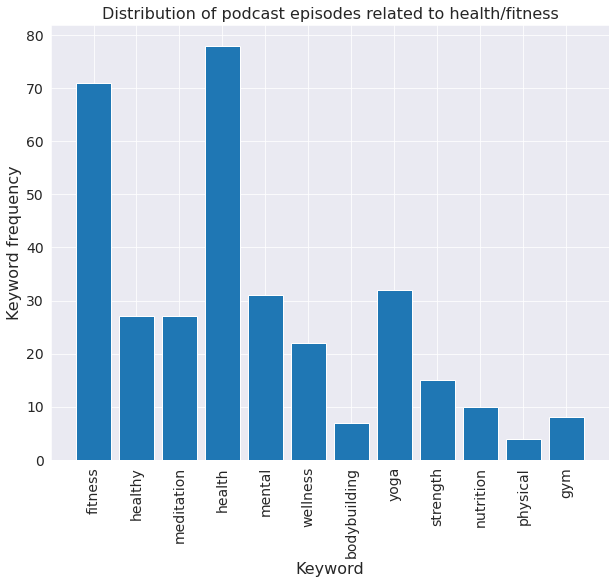

In [7]:
d = {}
for val in podcasts_genres_topics.values():
    for word in health_keywords:
        if word in val:
            if word in d:
                d[word] += 1
            else:
                d[word] = 1
                
plt.figure(figsize=(10,8))
plt.bar(d.keys(),d.values())
plt.title('Distribution of podcast episodes related to health/fitness',fontsize=16)
plt.xlabel('Keyword',fontsize=16)
plt.ylabel('Keyword frequency',fontsize=16)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14);

In [26]:
number_of_topics = [5,6,7,8,9,10,15]
df_parameters = list(product([2,3,4,5,6,7,8,9,10],[0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
hyperparams = list(product(number_of_topics,df_parameters))
health_cs = []
with open('/home1/sgmark/capstone-project/model/coherence_scores_health_category.csv','r') as f:
    reader = csv.reader(f)
    for row in reader:
        health_cs.append([float(x) for x in row])
        
best_hp_setting = hyperparams[np.argmax([x[5] for x in health_cs])]

In [27]:
best_hp_setting

(6, (2, 0.8))

#### The individual transcript location

In [10]:
def file_location(show,episode):
    search_string = local_path + "/spotify-podcasts-2020" + "/podcasts-transcripts" \
                               + "/" + show[0] \
                               + "/" + show[1] \
                               + "/" + "show_" + show \
                               + "/"
    return search_string

#### load the transcripts

In [11]:
transcripts = {}
for podcast,genre in health_category:
    for i in shows.get_group(podcast[1])[['show_filename_prefix','episode_filename_prefix']].index:
        show,episode = shows.get_group(podcast[1])[['show_filename_prefix','episode_filename_prefix']].loc[i]
        s = show.split("_")[1]
        try:
            with open('../podcast_transcripts/'+s[0]+'/'+s[1]+'/'+show+'/'+episode+'.txt','r') as f:
                transcripts[(show,episode)] = f.readlines()
            f.close()
        except Exception as e:
            pass
    
keys = list(transcripts.keys())

In [12]:
# Cleaning & remove urls and links
def remove_stops(text,stops):
    final = []
    for word in text:
        if (word not in stops) and (len(word)>3) and (not word.endswith('ing')) and (not word.endswith('ly')):
            final.append(word)
    return final
                       
def clean_text(docs):
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.extend(clean_doc)
    return final

def lemmatization(text_data): 
    nlp = spacy.load("en_core_web_sm")
    texts = []
    for text in text_data:
        doc = nlp(text)
        lem_text = []
        for token in doc:
            if (token.pos_=="VERB") or (token.pos_=="ADV"):
                pass
            else:
                lem_text.append(token.lemma_)
        texts.append(lem_text)
    return texts

#### tokenize/convert text into words

In [28]:
def normalize_docs(text_data):
    final_texts = []
    for text in text_data:
        new_text = gensim.utils.simple_preprocess(text,deacc=True)
        final_texts.append(new_text)
    return final_texts

In [29]:
docs = []
for text in transcripts.values():
    docs.append(' '.join(clean_text(normalize_docs(text))))
    
texts = lemmatization(docs)
texts = [remove_stops(text,stops) for text in texts]

### Using bigrams

In [30]:
from gensim.models.phrases import Phrases

bigram = Phrases(texts, min_count=5)

for i in range(len(texts)):
    for token in bigram[texts[i]]:
        if '_' in token:
            texts[i].append(token)

#### Construct a corpus of words as a bag of words 

In [31]:
dictionary = corpora.Dictionary(texts)

dictionary.filter_extremes(no_below=best_hp_setting[1][0],no_above=best_hp_setting[1][1])

In [32]:
corpus = [dictionary.doc2bow(text) for text in texts]

####  Hyperparameter tuning

In [ ]:
# from itertools import product

# number_of_topics = [5,6,7,8,9,10,15]
# df_parameters = list(product([2,3,4,5,6,7,8,9,10],[0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
# coherence_scores_umass = np.zeros((len(number_of_topics),len(df_parameters)))
# coherence_scores_uci = np.zeros((len(number_of_topics),len(df_parameters)))
# coherence_scores_npmi = np.zeros((len(number_of_topics),len(df_parameters)))

# j = 0
# for num in number_of_topics:
#     i = 0
#     for n,m in df_parameters:
#         dictionary = corpora.Dictionary(texts)
#         dictionary.filter_extremes(no_below=n,no_above=m)
#         corpus = [dictionary.doc2bow(text) for text in texts]
#         num_topics = num
#         chunksize = 200
#         passes = 20
#         iterations = 500
#         eval_every = None

#         lda_model = gensim.models.ldamodel.LdaModel(corpus,
#                                                    id2word=dictionary,
#                                                    num_topics=num_topics,
#                                                    chunksize=chunksize,
#                                                    passes=passes,
#                                                    iterations=iterations,
#                                                    alpha='auto',
#                                                    eta='auto',
#                                                    random_state = 123,
#                                                    eval_every=eval_every)
#         cm = CoherenceModel(lda_model, texts=texts,corpus=corpus, coherence= 'c_uci')
#         coherence_scores_uci[j,i] = cm.get_coherence()
#         cm = CoherenceModel(lda_model, texts=texts,corpus=corpus, coherence= 'c_npmi')
#         coherence_scores_npmi[j,i] = cm.get_coherence() 
#         cm = CoherenceModel(lda_model, corpus=corpus, coherence= 'u_mass')
#         coherence_scores_umass[j,i] = cm.get_coherence()
#         with open("coherence_scores_health_category.csv",'a') as f:
#             writer = csv.writer(f)
#             writer.writerow([num,n,m,coherence_scores_uci[j,i],coherence_scores_npmi[j,i],\
#                              coherence_scores_umass[j,i]])
#         i += 1
#         print(i)
#     j += 1
#     print(j)

#### Final model

In [33]:
%%time
import logging
logging.basicConfig(filename='health_topics.log', encoding='utf-8',format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

num_topics = best_hp_setting[0]
chunksize = 200
passes = 50
iterations = 500
eval_every = None

lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           chunksize=chunksize,
                                           passes=passes,
                                           iterations=iterations,
                                           alpha='auto',
                                           eta='auto',
                                           random_state=123,
                                           eval_every=eval_every)

CPU times: user 59.1 s, sys: 44.7 ms, total: 59.2 s
Wall time: 59.3 s


In [34]:
top_topics = lda_model.top_topics(corpus,texts=texts,coherence='c_npmi') #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics])/num_topics

print('Average topic coherence: %.4f.' % avg_topic_coherence)
print(f'topic coherence scores: {[t[1] for t in top_topics]}')

Average topic coherence: 0.0546.
topic coherence scores: [0.18276024181007558, 0.0391305644149505, 0.037255217356951274, 0.03192544614843019, 0.025048462935694182, 0.011751226095566536]


### Visualizing data

In [85]:
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,dictionary,mds="mmds",R=20)
pyLDAvis.save_html(vis,'health_umass.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.008161  0.056704       1        1  38.864529
1      0.218994  0.000201       2        1  18.438688
5     -0.243223  0.109900       3        1  14.363416
3      0.138400 -0.296350       4        1  10.678352
0      0.072451  0.378416       5        1   9.482894
2     -0.178461 -0.248871       6        1   8.172121, topic_info=         Term         Freq        Total Category  logprob  loglift
703      hand  3608.000000  3608.000000  Default  20.0000  20.0000
951      food  6677.000000  6677.000000  Default  19.0000  19.0000
1265    sugar  2574.000000  2574.000000  Default  18.0000  18.0000
2037     foot  2716.000000  2716.000000  Default  17.0000  17.0000
2773     knee  2458.000000  2458.000000  Default  16.0000  16.0000
...       ...          ...          ...      ...      ...      ...
336     brain   480.436129  1406.417022   Topic6  -5.0255   1.4303
63       body   790.982969  9062.850054   Topic6  -4.5269   0.0658
223      meal   482.756643  2225.277824   Topic6  -5.0207   0.9763
123     level   492.401449  2980.048688   Topic6  -5.0009   0.7040
1157  problem   486.985497  3006.522555   Topic6  -5.0120   0.6841

[312 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
294        1  0.523706          able
294        2  0.170894          able
294        3  0.203235          able
294        4  0.052554          able
294        5  0.037854          able
...      ...       ...           ...
3142       3  0.791119          yoga
3142       5  0.208797          yoga
6315       3  0.997237  yoga_teacher
12258      3  0.992275          yogi
9139       4  0.995960          zinc

[656 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 6, 4, 1, 3])

In [ ]:
# from pprint import pprint
# pprint(top_topics)

In [20]:
# import pickle

# pickle.dump(lda_model,open('../model/health_episodes_lda_model_uci_npmi.pkl','wb'))
# pickle.dump(dictionary,open('../model/health_episodes_dictionary_uci_npmi.pkl','wb'))
# pickle.dump(corpus,open('../model/health_episodes_corpus_uci_npmi.pkl','wb'))
# pickle.dump(texts,open('../model/health_episodes_texts.pkl','wb'))

In [18]:
# import pickle

# file = open('../model/health_episodes_lda_model.pkl','rb')
# lda_model = pickle.load(file)
# file.close()

# file = open('../model/health_episodes_corpus.pkl','rb')
# corpus = pickle.load(file)
# file.close()

# file = open('../model/health_episodes_dictionary.pkl','rb')
# dictionary = pickle.load(file)
# file.close()

In [35]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    podcast_list = []
    episode_list = []
    duration_list = []
    publisher_list = []
    show_prefix_list = []
    episode_prefix_list = []
    descriptions_list = []
    
    for key,wc in zip(keys,bow):
        show_prefix_list.append(key[0])
        episode_prefix_list.append(key[1])
        podcast_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].show_name.iloc[0])
        episode_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].episode_name.iloc[0])
        duration_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].duration.iloc[0])
        publisher_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].publisher.iloc[0])
        descriptions_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].episode_description.iloc[0])
        
        
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(show_prefix_list, name='show_filename_prefix'),
                           pd.Series(episode_prefix_list, name='episode_filename_prefix'),
                           pd.Series(podcast_list, name='Podcast_name'),
                           pd.Series(episode_list, name='Episode_name'),
                           pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords'),
                           pd.Series(duration_list, name='Duration of the episode'),
                           pd.Series(publisher_list, name='Publisher of the show'),
                           pd.Series(descriptions_list, name='Description of the episode')], axis=1)

    return result_df

In [36]:
main_topic_df = get_main_topic_df(lda_model,corpus,texts)
main_topic_df.to_pickle('health_topics_main_df_umass.pkl')

In [37]:
main_topic_df.head(5)

show_filename_prefix episode_filename_prefix  \
0  show_0RsrVs9sRhRhpvtmWr4gOV  1iTa8ULZbLTWnU48oojIjn   
1  show_2DqTRtd2IXURsFtGsxhFer  0hBsiNwzcJG6groHppjQ6s   
2  show_5Flo6LRekS0k1GL89FcCeo  3Dz6Vjz5CMU5btMA2igZlA   
3  show_5Flo6LRekS0k1GL89FcCeo  3nZGWX8ZoOYIDsvw7XmWLv   
4  show_5Flo6LRekS0k1GL89FcCeo  5ozUXEOvGTCTRHVSnLKawA   

                      Podcast_name  \
0               Best Fitness Blogs   
1  21 Days of Abundance Meditation   
2     21-Day Meditation Experience   
3     21-Day Meditation Experience   
4     21-Day Meditation Experience   

                                        Episode_name  Dominant_topic  Percent  \
0                      10 Best Fitness Blogs in 2020               4    0.744   
1  21 Days of Abundance Meditation with Binaural ...               5    0.612   
2             Day 1 - The Path to Grace Begins Today               5    0.997   
3             Day 3 - Awaken the Energy of Gratitude               5    0.967   
4                    Day 2 - Gratitude Is Within You               5    0.981   

                                      Processed_text  \
0  [fitness, blog, lifestyle, disease, mission, h...   
1    [chopra, center, addict, sure, thank, designer]   
2  [deepak, special, meditation, experience, grac...   
3  [energy, gratitude, unique, kind, power, grati...   
4  [thankful, moment, present, gratitude, open, g...   

                                            Keywords Duration of the episode  \
0  business different fitness happy hard kind mea...      1.6940333333333333   
1  body class different experience love mind prac...      15.274083333333332   
2  body class different experience love mind prac...                 21.3748   
3  body class different experience love mind prac...      18.965999999999998   
4  body class different experience love mind prac...                  20.816   

          Publisher of the show  \
0                    mary glory   
1                   Seanhawk754   
2  21-Day Meditation Experience   
3  21-Day Meditation Experience   
4  21-Day Meditation Experience   

                          Description of the episode  
0  lifestyle diseases! They rank best in the miss...  
1  Hello everyone!   Welcome to the 21 Days of ab...  
2  Day 1 - The Path to Grace Begins Today “Let gr...  
3  Day 3 - Awaken the Energy of Gratitude “Joy is...  
4  Day 2 - Gratitude Is Within You “Gratitude is ...

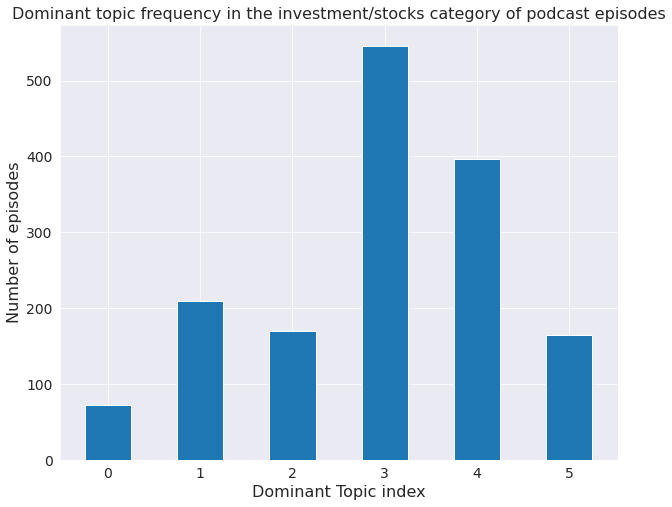

In [54]:
plt.figure(figsize=(10,8))
topics_groups = main_topic_df.groupby('Dominant_topic')
plt.bar(range(best_hp_setting[0]),topics_groups.count()['Podcast_name'],width=0.5)
plt.title('Dominant topic frequency in the investment/stocks category of podcast episodes',fontsize=16)
plt.xlabel('Dominant Topic index',fontsize=16)
plt.ylabel('Number of episodes',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [55]:
representatives = pd.DataFrame()

for k in topics_groups.groups.keys():
    representatives = pd.concat([representatives, 
                                 topics_groups.get_group(k).sort_values(['Percent'], ascending=False).head(1)])
    
for k,words in enumerate(representatives.Keywords):
    print(f'topic {k}: {words}')

topic 0: body breath exhale floor foot hand inhale knee shoulder spine
topic 1: body calorie diet food healthy kind loss meal protein weight
topic 2: blood blood_sugar body carb diet high insulin protein resistance sugar
topic 3: berg body course healthy intermittent level link problem video vitamin
topic 4: business different fitness happy hard kind mean money person point
topic 5: body class different experience love mind practice self teacher yoga


In [ ]:
# print('Document: {}  Dominant topic: {}\n'.format(representatives.index[2], 
#                                        representatives.loc[representatives.index[2]]['Dominant_topic']))
# print([sentence.strip() for sentence in transcripts[keys[representatives.index[2]]]])

In [56]:
num_topics = best_hp_setting[0]
def word_count_by_topic(topic=0):
    d_lens = [len(d) for d in topics_groups.get_group(topic)['Processed_text']]
    plt.figure(figsize=(10,8))
    plt.hist(d_lens)
    large = plt.gca().get_ylim()[1]
    d_mean = round(np.mean(d_lens), 1)
    d_median = np.median(d_lens)
    plt.plot([d_mean, d_mean], [0,large], label='Mean = {}'.format(d_mean))
    plt.plot([d_median, d_median], [0,large], label='Median = {}'.format(d_median))
    plt.legend()
    plt.xlabel('Document word count',fontsize=16)
    plt.ylabel('Number of documents',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

In [57]:
from ipywidgets import interact, IntSlider

slider = IntSlider(min=0, max=num_topics-1, step=1, value=0, description='Topic')
interact(word_count_by_topic, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=5), Output()), _dom_classes=('widget-interac…

In [58]:
lda_top_words_index = set()
for i in range(lda_model.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model.get_topic_terms(i)])
#print('Indices of top words: \n{}\n'.format(lda_top_words_index))

In [59]:
words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in list(lda_top_words_index)} 
                       for lst in corpus]

In [60]:
lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Cluster'] = main_topic_df['Dominant_topic']

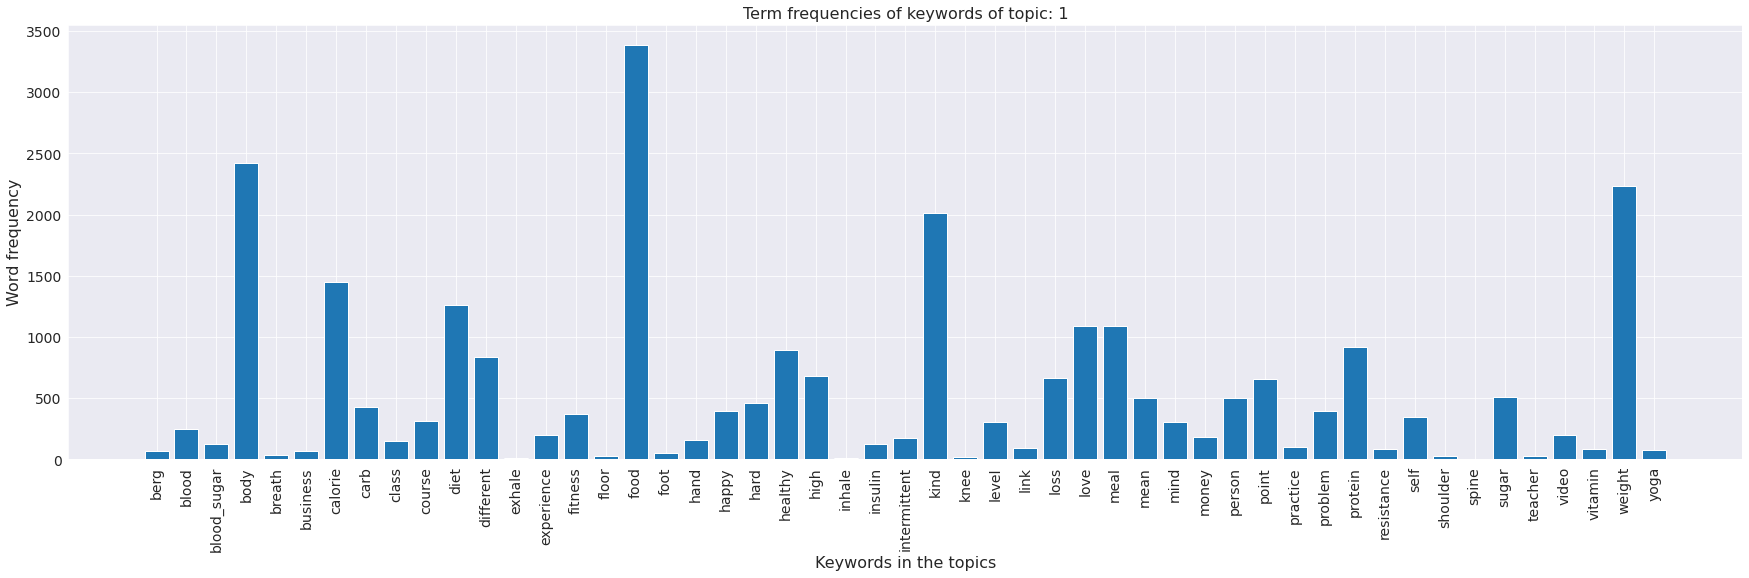

In [61]:
k=1
clusterwise_words_dist = lda_top_words_df.groupby('Cluster').get_group(k)
plt.figure(figsize=(30,8))
plt.bar(list(clusterwise_words_dist.sum()[:-1].transpose().index),\
        list(clusterwise_words_dist.sum()[:-1].transpose()))
plt.title(f'Term frequencies of keywords of topic: {k}',fontsize=16)
plt.xlabel('Keywords in the topics',fontsize=16)
plt.ylabel('Word frequency',fontsize=16)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14);

In [62]:
word_totals = {k:{y[1]:y[0] for y in x[0]} for k,x in enumerate(top_topics)}

In [63]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from wordcloud import WordCloud

def show_wordcloud(topic=0):
    cloud = WordCloud(background_color='white', colormap='viridis')
    cloud.generate_from_frequencies(word_totals[topic])
    plt.figure(figsize=(10,8))
    plt.gca().imshow(cloud)
    plt.axis('off')
    plt.tight_layout()
    
slider = IntSlider(min=0, max=best_hp_setting[0]-1, step=1, value=0, description='Topic')
interact(show_wordcloud, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=5), Output()), _dom_classes=('widget-interac…